<a href="https://colab.research.google.com/github/rachelxhoot/UCSD_ECE253_Fall2024/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dataset download



In [1]:
!wget -O ISIC-2017_Training_Data.zip "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
!unzip ISIC-2017_Training_Data.zip

!wget -O ISIC-2017_Training_Part1_GroundTruth.zip "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"
!unzip ISIC-2017_Training_Part1_GroundTruth.zip


Streaming output truncated to the last 5000 lines.
  inflating: ISIC-2017_Training_Data/ISIC_0003056_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003174.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003174_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003308.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003308_superpixels.png  
 extracting: ISIC-2017_Training_Data/ISIC_0003346.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003346_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0003728.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0003728_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004110.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004110_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004115.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004115_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0004166.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0004166_superpixels.png  
  inflating: 

# Libraries

In [2]:
!pip install segmentation-models-pytorch
!pip install torchinfo
!pip install torch torchvision gradio

import torch
import segmentation_models_pytorch as smp
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Image manipulation
from PIL import Image


# Image Preprosessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6dcf79e01dcff865df3a26c110136cd63f9eb4dce2b1d0330e4a78f9c9f08763
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=723d388e66f64190077c94626db6229492310f22eb3fefccddc14cf263247717
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# utils

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## evaluation

In [4]:
def compute_accuracy_loss(model, data_loader, criterion, device="cuda"):

    accuracy = 0
    loss = 0

    # Disable gradient calculations for evaluation
    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):

            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            loss_batch = criterion(mask_pred, mask)
            loss += loss_batch.item()

            # Compute true positives, false positives, false negatives, and true negatives
            # using segmentation-models-pytorch metrics
            tp, fp, fn, tn = smp.metrics.get_stats(
                mask_pred,
                mask.int(),
                threshold=0.5,
                mode='binary'
            )

            # using micro-averaging
            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            accuracy += accuracy_batch

    avg_accuracy = accuracy / len(data_loader)
    avg_loss = loss / len(data_loader)

    return avg_accuracy, avg_loss


def compute_accuracy(model, data_loader, device="cuda"):
    accuracy = 0

    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):
            image = image.float().to(device)
            mask = mask.to(device)

            mask_pred = model(image)

            tp, fp, fn, tn = smp.metrics.get_stats(
                mask_pred,
                mask,
                threshold=0.5,
                mode='binary'
            )

            accuracy_batch = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            accuracy += accuracy_batch

    return accuracy / len(data_loader)


def compute_loss(model, data_loader, criterion, device="cuda"):
    loss = 0

    with torch.no_grad():
        for i, (image, mask) in enumerate(data_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)
            loss_batch = criterion(mask_pred,mask)

            loss += loss_batch.item()

    return loss / len(data_loader)


## metrics

In [5]:
def check_metrics(dataloader, model, device="cuda"):
    accuracy_list = []
    jaccard_list = []
    dice_list = []
    pix_acc_list = []
    specificity_list = []
    sensitivity_list = []

    with torch.no_grad():
        for image, mask in dataloader:
            image = image.to(device).type(torch.float32)
            mask = mask.to(device)
            pred = model(image)
            pred = (pred > 0.5).int()

            tp, fp, fn, tn = smp.metrics.get_stats(
                pred,
                mask,
                threshold=0.5,
                mode='binary'
            )

            # Compute intersection and union for Jaccard and Dice metrics
            intersection = torch.logical_and(pred, mask).sum().detach()
            union = torch.logical_or(pred, mask).sum().detach()

            # Sensitivity (Recall): TP / (TP + FN)
            sensitivity = smp.metrics.functional.sensitivity(tp, fp, fn, tn, reduction="micro")
            sensitivity_list.append(sensitivity)

            # Specificity: TN / (TN + FP)
            specificity = smp.metrics.functional.specificity(tp, fp, fn, tn, reduction="micro")
            specificity_list.append(specificity)

            # Pixel Accuracy: (TP + TN) / (Total Pixels)
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
            accuracy_list.append(accuracy)

            # Jaccard Index (Intersection over Union)
            jaccard_score = intersection / union
            jaccard_list.append(jaccard_score)

            # Dice Coefficient: (2 * Intersection) / (Sum of Predicted and Ground Truth Pixels)
            dice_score = (2.0 * intersection) / (pred.sum().detach() + mask.sum().detach())
            dice_list.append(dice_score)


    sensitivity = torch.mean(torch.stack(sensitivity_list)).item()
    specificity = torch.mean(torch.stack(specificity_list)).item()
    pix_acc = torch.mean(torch.stack(accuracy_list)).item()
    jaccard = torch.mean(torch.stack(jaccard_list)).item()
    dice = torch.mean(torch.stack(dice_list)).item()

    print(f"Sensitivity: {sensitivity:.6f}")
    print(f"Specificity: {specificity:.6f}")
    print(f"Pixel Accuracy: {pix_acc:.6f}")
    print(f"Jaccard Score: {jaccard:.6f}")
    print(f"Dice Score: {dice:.6f}")

    return sensitivity, specificity, pix_acc, jaccard, dice


## train utils

In [6]:
def train_model(model, num_epochs, train_loader, valid_loader, criterion,
                optimizer, device, scheduler=None, scheduler_on='valid_loss'): # valid_loss or train_loss

    train_loss_list, valid_loss_list, valid_acc_list = [], [],  []

    for epoch in tqdm(range(num_epochs)):

        batch_loss_list = []
        model.train()
        for batch_idx, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            loss = criterion(mask_pred,mask)
            optimizer.zero_grad() # Zero out gradients from the previous step

            loss.backward()

            optimizer.step()

            batch_loss_list.append(loss.item())

        model.eval()

        with torch.no_grad():
            train_loss =  sum(batch_loss_list) / len(batch_loss_list)
            valid_acc, valid_loss = compute_accuracy_loss(model, valid_loader, criterion, device=device)

            print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
                  f'| Train Loss: {train_loss :.4f} '
                  f'| Validation Loss: {valid_loss :.4f} '
                  f'| Validation Accuracy: {valid_acc*100 :.1f}%')

            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            valid_acc_list.append(valid_acc)

        if scheduler is not None:
            if scheduler_on == 'valid_loss':
                scheduler.step(valid_loss_list[-1])
            elif scheduler_on == 'train_loss':
                scheduler.step(train_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    return train_loss_list, valid_loss_list, valid_acc_list


## plot

In [7]:
def plot_loss_accuracy(train_loss_list, val_loss_list, val_acc_list):
    num_epochs = len(train_loss_list)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(np.arange(1, num_epochs+1), train_loss_list, color="green", label='Train Loss')
    ax1.plot(np.arange(1, num_epochs+1), val_loss_list, color="red", label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.legend()

    ax2.plot(np.arange(1, num_epochs+1), val_acc_list, color="blue", label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


def plot_img_mask_pred(dataset, index=None, plot_pred=False, model=None, device = "cuda"):
    if not index:
        index = random.randint(0, len(dataset) - 1)

    image = dataset[index][0].permute(1,2,0)
    mask = dataset[index][1].permute(1,2,0)

    if plot_pred:
        img_to_pred = dataset[index][0].unsqueeze(0).type(torch.float32).to(device)
        pred = model(img_to_pred)
        pred = pred.squeeze(0).cpu().detach().permute(1,2,0)
        pred[pred < 0]=0
        pred[pred > 0]=1

        # Plot the image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Plot the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")

        # Show the plots
        plt.tight_layout()
        plt.show()

    else:
        # Plot the image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")

        # Show the plots
        plt.tight_layout()
        plt.show()



# Data Preprocessing

In [8]:
# settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate =5e-4
batch_size = 16
size =(128,128)

In [9]:
device # check device

device(type='cuda')

In [10]:
image_dir = "/content/ISIC-2017_Training_Data"
gt_dir = "/content/ISIC-2017_Training_Part1_GroundTruth"

image_paths = sorted([os.path.join(image_dir, fname)
                      for fname in os.listdir(image_dir)
                      if fname.endswith(".jpg")])
gt_paths = sorted([os.path.join(gt_dir, fname)
                    for fname in os.listdir(gt_dir)
                    if fname.endswith(".png")])
assert(len(image_paths) == len(gt_paths))

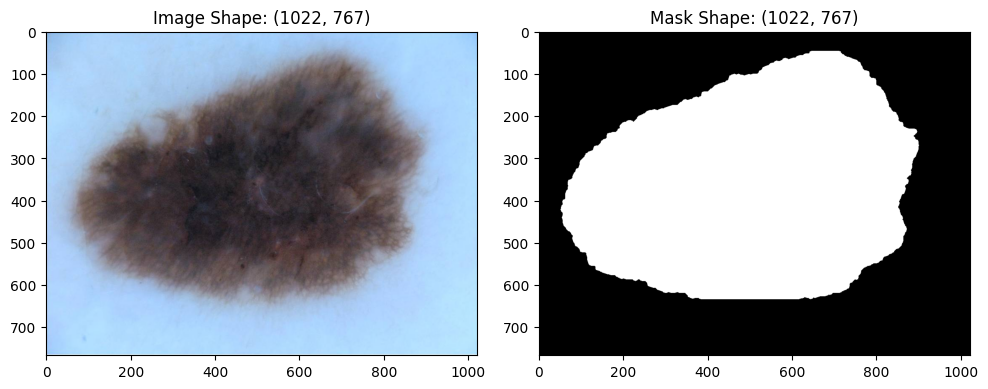

In [11]:
image_path = image_paths[0] # update idx
mask_path = gt_paths[0]

image = Image.open(image_path)
mask = Image.open(mask_path)

image_shape = image.size
mask_shape = mask.size

image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')
plt.title(f"Mask Shape: {mask_shape}")

plt.tight_layout()
plt.show()

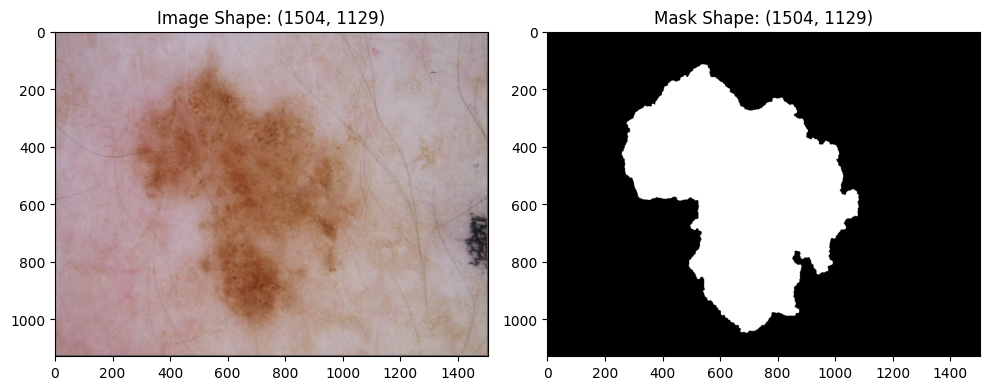

In [12]:
image_path = image_paths[20] # update idx
mask_path = gt_paths[20]

image = Image.open(image_path)
mask = Image.open(mask_path)

image_shape = image.size
mask_shape = mask.size

image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')
plt.title(f"Mask Shape: {mask_shape}")

plt.tight_layout()
plt.show()

In [13]:
percentage_test = 0.05
percentage_validation = 0.1
# random seed for reproducibility
random_seed = 142

# Split data into training, validation, and test sets
image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, gt_paths, test_size=percentage_test, random_state=random_seed)
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(image_paths_trainval, mask_paths_trainval, test_size=percentage_validation, random_state=random_seed)


In [14]:
class LesionSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask, 0)
        return img, mask

In [15]:
# Transformations

train_transform = A.Compose([
    A.Resize(size[0], size[1]),  # Resize
    A.Rotate(limit=15, p=0.1),  # Randomly rotate the image within a range of -15 to +15 degrees with a probability of 10%
    A.HorizontalFlip(p=0.5),    # Randomly flip the image horizontally with a probability of 50%
    A.Normalize(mean=(0, 0, 0),  # Normalize the image by setting the mean to 0 and standard deviation to 1 for each channel
               std=(1, 1, 1),   # The standard deviation for normalization
               max_pixel_value=255),  # Scale the pixel values to [0, 1] by dividing by the maximum pixel value (255)
    ToTensorV2()  # Convert the processed image to a PyTorch tensor format
])

val_transform = A.Compose([
    A.Resize(size[0], size[1]),  # Resize
    A.Normalize(mean=(0, 0, 0),  # Normalize the image by setting the mean to 0 and standard deviation to 1 for each channel
               std=(1, 1, 1),   # The standard deviation for normalization
               max_pixel_value=255),  # Scale the pixel values to [0, 1] by dividing by the maximum pixel value (255)
    ToTensorV2()  # Convert the processed image to a PyTorch tensor format
])


In [16]:
train_dataset =  LesionSegmentationDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = LesionSegmentationDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = LesionSegmentationDataset(image_paths_test, mask_paths_test, transform = val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

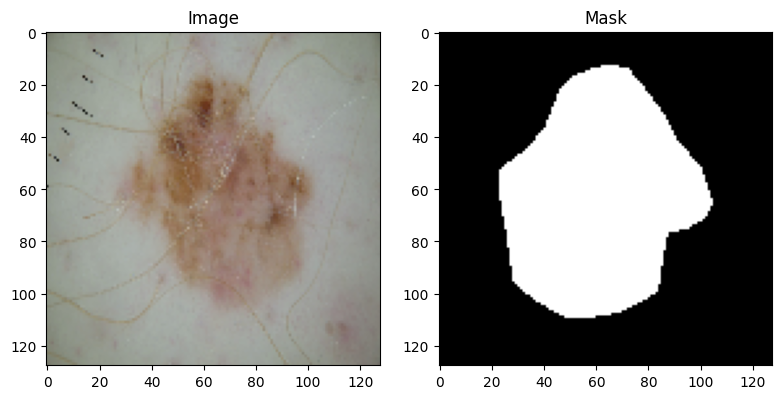

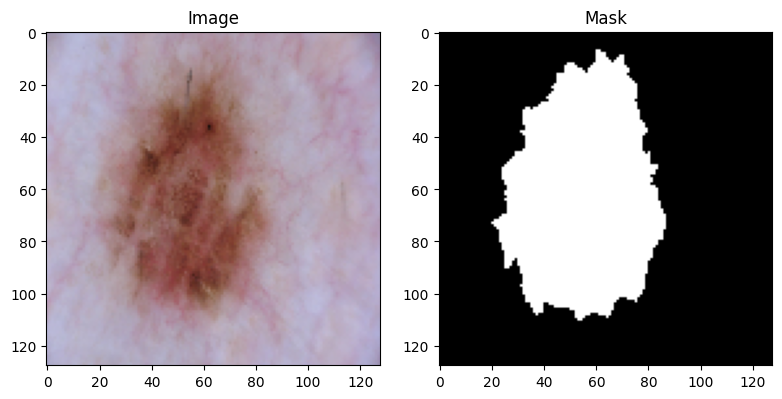

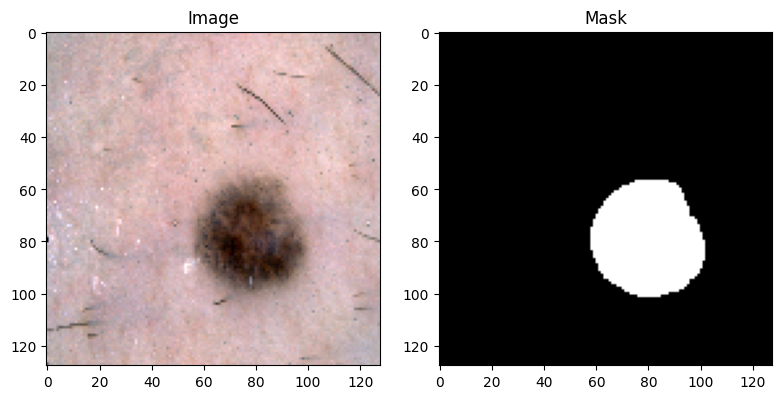

In [17]:
plot_img_mask_pred(train_dataset)

plot_img_mask_pred(val_dataset)

plot_img_mask_pred(test_dataset)



# Model

In [18]:
# basic convolutional block (two convolutional layers + ReLU activations)
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1)  # First convolution
        self.relu = nn.ReLU()  # ReLU activation
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)  # Second convolution

    def forward(self, x):
        # Apply two convolutions with ReLU activations
        return self.relu(self.conv2(self.relu(self.conv1(x)))).to(device)


# encoder part of U-Net
class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)  # Max pooling operation to reduce spatial dimensions by half

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


# Define the decoder part of U-Net
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        """
        Args:
            chs: A tuple defining the number of input and output channels for each decoder block.
        """
        super().__init__()
        self.chs = chs
        # up-convolution layers for upsampling
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs) - 1)])
        # convolutional blocks for feature processing
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


# U-Net architecture
class UNet(nn.Module):
    def __init__(self, enc_chs=(3, 64, 128, 256, 512, 1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], num_class, 1)

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out


In [19]:
model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)

# 优化器 Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# other options
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=learning_rate/epochs) # RMSprop 添加权重衰减
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate) # 带动量的SGD

# 损失函数 Loss
criterion = nn.BCEWithLogitsLoss() # 带有Logits的二值交叉熵损失（适合用于二分类问题）

#criterion = SoftBCEWithLogitsLoss() # 带Logits的软二值交叉熵损失
#criterion = JaccardLoss() # Jaccard（IoU）损失函数 优化分割任务中的交并比

# 学习率调度器：ReduceLROnPlateau
# 当验证损失（默认min模式）在`patience`轮内没有改善时，将学习率减少`factor`倍
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [20]:
summary(model, input_size=(batch_size,3, size[0],size[1]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 128, 128]         --
├─Encoder: 1-1                           [16, 32, 128, 128]        --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [16, 32, 128, 128]        10,144
│    └─MaxPool2d: 2-2                    [16, 32, 64, 64]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [16, 64, 64, 64]          55,424
│    └─MaxPool2d: 2-4                    [16, 64, 32, 32]          --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [16, 128, 32, 32]         221,440
│    └─MaxPool2d: 2-6                    [16, 128, 16, 16]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4              

# Train

In [21]:
epochs = 50

In [ ]:
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(
    model,
    epochs,
    train_dataloader,
    val_dataloader,

    criterion,
    optimizer,
    device,
    scheduler=scheduler,
    scheduler_on='train_loss'
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 01/50 | Train Loss: 0.4412 | Validation Loss: 0.3356 | Validation Accuracy: 82.9%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 02/50 | Train Loss: 0.3446 | Validation Loss: 0.3082 | Validation Accuracy: 87.2%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 03/50 | Train Loss: 0.3059 | Validation Loss: 0.2697 | Validation Accuracy: 89.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 04/50 | Train Loss: 0.2724 | Validation Loss: 0.3900 | Validation Accuracy: 86.7%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 05/50 | Train Loss: 0.2307 | Validation Loss: 0.1912 | Validation Accuracy: 93.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 06/50 | Train Loss: 0.1707 | Validation Loss: 0.1714 | Validation Accuracy: 93.3%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 07/50 | Train Loss: 0.1649 | Validation Loss: 0.1385 | Validation Accuracy: 94.9%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 08/50 | Train Loss: 0.1503 | Validation Loss: 0.1363 | Validation Accuracy: 94.7%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 09/50 | Train Loss: 0.1436 | Validation Loss: 0.1312 | Validation Accuracy: 94.5%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 10/50 | Train Loss: 0.1384 | Validation Loss: 0.1235 | Validation Accuracy: 95.5%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 11/50 | Train Loss: 0.1347 | Validation Loss: 0.1204 | Validation Accuracy: 95.5%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 12/50 | Train Loss: 0.1320 | Validation Loss: 0.1174 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 13/50 | Train Loss: 0.1259 | Validation Loss: 0.1162 | Validation Accuracy: 95.7%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 14/50 | Train Loss: 0.1260 | Validation Loss: 0.1136 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 15/50 | Train Loss: 0.1273 | Validation Loss: 0.1220 | Validation Accuracy: 95.7%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 16/50 | Train Loss: 0.1159 | Validation Loss: 0.1174 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 17/50 | Train Loss: 0.1263 | Validation Loss: 0.1324 | Validation Accuracy: 95.7%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 18/50 | Train Loss: 0.1244 | Validation Loss: 0.1145 | Validation Accuracy: 95.3%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 19/50 | Train Loss: 0.1158 | Validation Loss: 0.1068 | Validation Accuracy: 96.0%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 20/50 | Train Loss: 0.1109 | Validation Loss: 0.1092 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 21/50 | Train Loss: 0.1103 | Validation Loss: 0.1186 | Validation Accuracy: 95.3%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 22/50 | Train Loss: 0.1098 | Validation Loss: 0.1058 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 23/50 | Train Loss: 0.1048 | Validation Loss: 0.1084 | Validation Accuracy: 95.4%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 24/50 | Train Loss: 0.1048 | Validation Loss: 0.1109 | Validation Accuracy: 96.0%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 25/50 | Train Loss: 0.1064 | Validation Loss: 0.1292 | Validation Accuracy: 94.8%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 26/50 | Train Loss: 0.1023 | Validation Loss: 0.1052 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 27/50 | Train Loss: 0.1017 | Validation Loss: 0.1044 | Validation Accuracy: 95.8%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 28/50 | Train Loss: 0.0990 | Validation Loss: 0.1049 | Validation Accuracy: 96.0%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 29/50 | Train Loss: 0.1033 | Validation Loss: 0.1049 | Validation Accuracy: 96.1%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 30/50 | Train Loss: 0.1000 | Validation Loss: 0.1070 | Validation Accuracy: 95.8%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 31/50 | Train Loss: 0.1003 | Validation Loss: 0.1000 | Validation Accuracy: 96.2%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 32/50 | Train Loss: 0.0990 | Validation Loss: 0.0969 | Validation Accuracy: 96.2%


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch: 33/50 | Train Loss: 0.0982 | Validation Loss: 0.1199 | Validation Accuracy: 95.6%


  0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

In [ ]:
model.eval()

# Saving

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/segmentation_model.pth')

# Initialize an empty model with the same architecture
# upload_model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)

# Load the model from Google Drive
# model_path = '/content/drive/My Drive/model.pth'
# upload_model.load_state_dict(torch.load(model_path,  map_location=torch.device('cpu')))
# upload_model.eval()
# upload_model.to(device)


# Visulization

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import gradio as gr

model_path = '/content/drive/MyDrive/segmentation_model.pth'

upload_model = UNet(enc_chs=(3,32, 64,128,256), dec_chs=(256, 128, 64, 32), num_class=1)
upload_model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
upload_model.eval()
upload_model.to(device)

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),
    ToTensorV2()
])

def preprocess_image(image):
    image = np.array(image)
    transformed = transform(image=image)
    tensor = transformed["image"].unsqueeze(0).to(device)
    return tensor

def postprocess_mask(mask):
    mask = mask.squeeze().cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8) * 255
    return mask

def predict(image):
    input_tensor = preprocess_image(image)
    with torch.no_grad():
        mask = model(input_tensor)
    mask = postprocess_mask(mask)
    return mask

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Image(type="numpy", label="Predicted Segmentation"),
    title="U-Net Lesion Segmentation",
    description="Upload an image to perform lesion segmentation using a pre-trained U-Net model."
)

demo.launch()